In [3]:
import numpy as np
import matplotlib.pyplot as plt
import sys
import os
import copy
import pandas as pd
import time
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import matplotlib.pyplot as plt

# Loading in data

In [4]:
print("Loading")
path_Ben_linux_1 = "/home/rubin/Research/data/metadata_IMU_EMG_allgestures_allusers(1).pkl"

start_time = time.time()
data_df = pd.read_pickle(path_Ben_linux_1)
end_time = time.time()
print(f"Completed in {end_time - start_time}s")

Loading
Completed in 0.08627796173095703s


# Split Dataset into train and test split

In [6]:
# Impaired participants
pIDs_impaired = ['P102', 'P103', 'P104', 'P105', 'P106', 'P107', 'P108', 'P109', 'P110', 'P111',
                 'P112', 'P114', 'P115', 'P116', 'P118', 'P119', 'P121', 'P122', 'P123', 'P124', 
                 'P125', 'P126', 'P127', 'P128', 'P131', 'P132']

# Unimpaired participants
pIDs_unimpaired = ['P004', 'P005', 'P006', 'P008', 'P010', 'P011']

def split_and_preprocess_by_user(data_df, pIDs_impaired, pIDs_unimpaired, test_size=0.2):
    # Split impaired and unimpaired participants into train and test sets
    impaired_train, impaired_test = train_test_split(pIDs_impaired, test_size=test_size, random_state=42)
    unimpaired_train, unimpaired_test = train_test_split(pIDs_unimpaired, test_size=test_size, random_state=42)

    # Combine train and test users
    training_users = impaired_train + unimpaired_train
    test_users = impaired_test + unimpaired_test

    metadata_cols = ['Participant', 'Gesture_ID', 'Gesture_Num']

    # Split data by users
    train_df = data_df[data_df['Participant'].isin(training_users)]
    test_df = data_df[data_df['Participant'].isin(test_users)]

    # Subset metadata columns for training and testing sets
    train_metadata_df = train_df[metadata_cols].reset_index(drop=True)
    test_metadata_df = test_df[metadata_cols].reset_index(drop=True)

    # Drop metadata columns from the dataframes
    train_df = train_df.drop(metadata_cols, axis=1).reset_index(drop=True)
    test_df = test_df.drop(metadata_cols, axis=1).reset_index(drop=True)

    # Scale the data
    train_scaler = StandardScaler()

    # Fit on training data and transform both train and test sets
    ppd_train_df = pd.DataFrame(train_scaler.fit_transform(train_df))
    ppd_test_df = pd.DataFrame(train_scaler.transform(test_df))

    # Split IMU and EMG data
    ppd_train_imu_df = ppd_train_df.iloc[:, :72]
    ppd_train_emg_df = ppd_train_df.iloc[:, 72:]
    ppd_test_imu_df = ppd_test_df.iloc[:, :72]
    ppd_test_emg_df = ppd_test_df.iloc[:, 72:]

    # Concatenate metadata back to the processed data
    ppd_train_imu_df = pd.concat([train_metadata_df, ppd_train_imu_df], axis=1)
    ppd_train_emg_df = pd.concat([train_metadata_df, ppd_train_emg_df], axis=1)
    ppd_test_imu_df = pd.concat([test_metadata_df, ppd_test_imu_df], axis=1)
    ppd_test_emg_df = pd.concat([test_metadata_df, ppd_test_emg_df], axis=1)

    return ppd_train_imu_df, ppd_train_emg_df, ppd_test_imu_df, ppd_test_emg_df

# Call the function with the full participant list
ppd_train_imu_df, ppd_train_emg_df, ppd_test_imu_df, ppd_test_emg_df = split_and_preprocess_by_user(data_df, pIDs_impaired, pIDs_unimpaired)


In [7]:
print(ppd_train_imu_df.shape)
ppd_train_emg_df.head()

(153600, 75)


,Participant,Gesture_ID,Gesture_Num,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87
0,P103,move,1,-0.272553,-0.174909,-0.487032,-0.479092,-0.282206,-0.340962,-0.349967,-0.372957,-0.460476,-0.322696,-0.353601,-0.359954,-0.341444,-0.270736,-0.129773,-0.256569
1,P103,move,1,-0.237541,-0.219476,-0.491541,-0.456715,-0.259345,-0.269619,-0.370232,-0.354646,-0.456982,-0.301867,-0.349724,-0.356034,-0.337765,-0.281176,-0.106944,-0.250600
2,P103,move,1,-0.226202,-0.227727,-0.498172,-0.514807,-0.247238,-0.248624,-0.340924,-0.330598,-0.453981,-0.294390,-0.355787,-0.360192,-0.341552,-0.274673,-0.068181,-0.182230
3,P103,move,1,-0.059969,-0.167775,-0.476214,-0.597320,-0.266217,-0.281169,-0.308048,-0.280282,-0.518521,-0.294813,-0.355749,-0.350663,-0.333018,-0.264322,-0.065513,-0.144634
4,P103,move,1,-0.012488,-0.202698,-0.483415,-0.510942,-0.278117,-0.243418,-0.328787,-0.316063,-0.439284,-0.295585,-0.346027,-0.350198,-0.327595,-0.256635,-0.112046,-0.256429


In [8]:
class EMG_IMU_Dataset(Dataset):
    def __init__(self, emg_df, imu_df, num_channels_emg=16, num_channels_imu=72, time_units=64):
        # Create labels array using only Gesture_ID from EMG data
        self.labels = emg_df['Gesture_ID'].values
        
        # Exclude metadata columns and reshape the EMG and IMU data
        emg_data = emg_df.drop(['Participant', 'Gesture_ID', 'Gesture_Num'], axis=1).values
        imu_data = imu_df.drop(['Participant', 'Gesture_ID', 'Gesture_Num'], axis=1).values

        # EMG data processing: (num_samples, time_units, num_channels_emg)
        num_samples_emg = len(emg_data) // time_units
        self.emg_data = emg_data.reshape(num_samples_emg, time_units, num_channels_emg).transpose((0, 2, 1))

        # IMU data processing: (num_samples, time_units, num_channels_imu)
        num_samples_imu = len(imu_data) // time_units
        self.imu_data = imu_data.reshape(num_samples_imu, time_units, num_channels_imu).transpose((0, 2, 1))

        # Create a dictionary to map each unique Gesture_ID to an integer label
        unique_labels = np.unique(self.labels)
        self.label_map = {label: i for i, label in enumerate(unique_labels)}
        
        # Map labels to integers
        self.labels = np.array([self.label_map[label] for label in self.labels[:num_samples_emg * time_units:time_units]])

        # Create a dictionary to map (Participant, Gesture_ID, Gesture_Num) to index
        self.index_map = {(row['Participant'], row['Gesture_ID'], row['Gesture_Num']): idx // time_units 
                          for idx, row in emg_df.iterrows()}

        # Sanity check
        print(f"EMG Data shape: {self.emg_data.shape}")
        print(f"IMU Data shape: {self.imu_data.shape}")
        print(f"Labels shape: {self.labels.shape}")
        print(f"Label mapping: {self.label_map}")
    
    def __len__(self):
        return len(self.emg_data)

    def __getitem__(self, idx):
        if isinstance(idx, tuple):
            # Get item by (Participant, Gesture_ID, Gesture_Num)
            idx = self.index_map[idx]
        
        emg_data = torch.tensor(self.emg_data[idx], dtype=torch.float32)
        imu_data = torch.tensor(self.imu_data[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        
        return emg_data, imu_data, label


In [9]:
from torch.utils.data import DataLoader

# Create dataset instances
train_dataset = EMG_IMU_Dataset(ppd_train_emg_df, ppd_train_imu_df)
test_dataset = EMG_IMU_Dataset(ppd_test_emg_df, ppd_test_imu_df)

# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


EMG Data shape: (2400, 16, 64)
IMU Data shape: (2400, 72, 64)
Labels shape: (2400,)
Label mapping: {'close': 0, 'delete': 1, 'duplicate': 2, 'move': 3, 'open': 4, 'pan': 5, 'rotate': 6, 'select-single': 7, 'zoom-in': 8, 'zoom-out': 9}
EMG Data shape: (800, 16, 64)
IMU Data shape: (800, 72, 64)
Labels shape: (800,)
Label mapping: {'close': 0, 'delete': 1, 'duplicate': 2, 'move': 3, 'open': 4, 'pan': 5, 'rotate': 6, 'select-single': 7, 'zoom-in': 8, 'zoom-out': 9}


In [10]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class EMG_IMU_CNN(nn.Module):
    def __init__(self, num_classes=10, dropout_prob=0.5, num_conv_layers=3, num_fcc_layers=2):
        super(EMG_IMU_CNN, self).__init__()

        # Initial channels for EMG and IMU data
        emg_in_channels = 16
        imu_in_channels = 72
        
        # Define convolutional layers for EMG and IMU data
        self.emg_convs = nn.ModuleList()
        self.imu_convs = nn.ModuleList()
        
        conv_channels = [32, 64, 128, 256, 512]  # Channel sizes you can vary

        # Add dynamic convolutional layers based on num_conv_layers
        for i in range(num_conv_layers):
            out_channels = conv_channels[i]
            
            # Convolutional block for EMG data
            self.emg_convs.append(nn.Conv1d(emg_in_channels, out_channels, kernel_size=3, padding=1))
            self.emg_convs.append(nn.BatchNorm1d(out_channels))
            emg_in_channels = out_channels
            
            # Convolutional block for IMU data
            self.imu_convs.append(nn.Conv1d(imu_in_channels, out_channels, kernel_size=3, padding=1))
            self.imu_convs.append(nn.BatchNorm1d(out_channels))
            imu_in_channels = out_channels

        # Pooling layer
        self.pool = nn.MaxPool1d(kernel_size=2)
        
        # Dropout layer
        self.dropout = nn.Dropout(p=dropout_prob)

        # Calculate the input size for the fully connected layers based on the final conv output size
        seq_length = 16  # Original sequence length before convolution and pooling
        reduced_seq_length = seq_length // (2 ** num_conv_layers)  # Assuming each pooling halves the length

        # *2 for concatenated EMG and IMU tensors
        fc_input_size = 2048

        # Define fully connected layers based on num_fcc_layers
        self.fc_layers = nn.ModuleList()
        fc_dims = [fc_input_size, 256, 128, 64]  # Example sizes of fully connected layers
        
        if num_fcc_layers > 1:
            self.fc_layers.append(nn.Linear(fc_dims[0], fc_dims[1]))  # First fully connected layer
        if num_fcc_layers > 2:
            self.fc_layers.append(nn.Linear(fc_dims[1], fc_dims[2]))  # Second fully connected layer
        if num_fcc_layers > 3:
            self.fc_layers.append(nn.Linear(fc_dims[2], fc_dims[3]))  # Third fully connected layer
        
        # Output layer for classification
        self.output_layer = nn.Linear(fc_dims[num_fcc_layers - 1], num_classes)

    def forward(self, emg_input, imu_input):

        # Forward pass through convolutional layers for EMG data
        for i in range(0, len(self.emg_convs), 2):
            emg_input = F.relu(self.emg_convs[i+1](self.emg_convs[i](emg_input)))
            emg_input = self.pool(emg_input)

        # Forward pass through convolutional layers for IMU data
        for i in range(0, len(self.imu_convs), 2):
            imu_input = F.relu(self.imu_convs[i+1](self.imu_convs[i](imu_input)))
            imu_input = self.pool(imu_input)
        
        # Flatten and concatenate EMG and IMU outputs
        emg_input = torch.flatten(emg_input, start_dim=1)
        imu_input = torch.flatten(imu_input, start_dim=1)
        
        x = torch.cat((emg_input, imu_input), dim=1)

        # Dropout after concatenation
        x = self.dropout(x)

        # Forward pass through fully connected layers
        for idx, fc in enumerate(self.fc_layers):
            x = self.dropout(F.relu(fc(x)))

        # Final output layer
        x = self.output_layer(x)
        
        return x


In [11]:
# Data Augmentation Functions for EMG and IMU Data

def scale_magnitude(data, scale_factor_range=(0.7, 1.3)):
    scale_factor = np.random.uniform(*scale_factor_range)
    return data * scale_factor

def time_shift(data, shift_max=5):
    shift = np.random.randint(-shift_max, shift_max)
    return torch.roll(data, shifts=shift, dims=-1)

# Apply data augmentation as a toggle
def apply_data_augmentation(emg_input, imu_input, augment=True):
    if augment:
        emg_input = scale_magnitude(emg_input)
        emg_input = time_shift(emg_input)
        
        imu_input = scale_magnitude(imu_input)
        imu_input = time_shift(imu_input)
    return emg_input, imu_input

# Function to evaluate the model on the test set
def evaluate_model(model, data_loader, criterion):
    model.eval()
    test_loss, correct, total = 0, 0, 0
    with torch.no_grad():
        for emg_input, imu_input, labels in data_loader:
            outputs = model(emg_input, imu_input)
            test_loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy, test_loss / len(data_loader)

# Function to train and evaluate with data augmentation toggle
def train_and_evaluate(num_conv_layers, num_fcc_layers, dropout_prob, weight_decay, train_loader, test_loader, augment_data=False, num_epochs=100):
    model = EMG_IMU_CNN(num_classes=10, dropout_prob=dropout_prob, num_conv_layers=num_conv_layers, num_fcc_layers=num_fcc_layers)
    
    optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=weight_decay)
    criterion = nn.CrossEntropyLoss()

    test_accuracies_at_checkpoints = []  # Store test accuracies at 20, 40, 60, 80, 100 epochs
    checkpoint_epochs = [20, 40, 60, 80, 100]  # Checkpoints to evaluate test accuracy

    for epoch in range(1, num_epochs + 1):
        model.train()
        for emg_input, imu_input, labels in train_loader:
            # Apply data augmentation only in training phase
            emg_input, imu_input = apply_data_augmentation(emg_input, imu_input, augment=augment_data)

            optimizer.zero_grad()
            outputs = model(emg_input, imu_input)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Check if current epoch is a checkpoint and evaluate test accuracy
        if epoch in checkpoint_epochs:
            test_accuracy, _ = evaluate_model(model, test_loader, criterion)
            test_accuracies_at_checkpoints.append(test_accuracy)
       
    return test_accuracies_at_checkpoints, checkpoint_epochs

# Hyperparameter tuning function with added data augmentation toggle
def hyperparameter_tuning(train_loader, test_loader):
    conv_layers = [2, 3, 4, 5]
    fcc_layers = [1, 2, 3,]
    dropout_probs = [0.4, 0.5, 0.6]
    weight_decays = [1e-4, 1e-3, 1e-2]
    augment_options = [True, False]  # Toggle for data augmentation

    results = []

    for conv in conv_layers:
        for fcc in fcc_layers:
            for dropout in dropout_probs:
                for wd in weight_decays:
                    for augment in augment_options:
                        test_acc, checkpoint_epochs = train_and_evaluate(conv, fcc, dropout, wd, train_loader, test_loader, augment_data=augment)
                        results.append({
                            'conv_layers': conv,
                            'fcc_layers': fcc,
                            'dropout_prob': dropout,
                            'weight_decay': wd,
                            'augment': augment,
                            'test_accuracies': test_acc,
                            'checkpoint_epochs': checkpoint_epochs
                        })
                        print(f"Conv: {conv}, FCC: {fcc}, Dropout: {dropout}, WD: {wd}, Augment: {augment} -> Test Acc at Checkpoints: {test_acc}")

    return results

# Plotting function for test accuracies at checkpoints
def plot_results(results):
    for result in results:
        augment_label = "With Augmentation" if result['augment'] else "Without Augmentation"
        plt.plot(result['checkpoint_epochs'], result['test_accuracies'], label=f"Conv: {result['conv_layers']}, FCC: {result['fcc_layers']}, Dropout: {result['dropout_prob']}, {augment_label}")
    
    plt.xlabel('Epochs')
    plt.ylabel('Test Accuracy (%)')
    plt.title('Test Accuracy at Epochs 20, 40, 60, 80, 100')
    plt.legend()
    plt.show()




Conv: 2, FCC: 1, Dropout: 0.4, WD: 0.0001, Augment: True -> Test Acc at Checkpoints: [21.75, 22.375, 23.625, 22.875, 23.75]
Conv: 2, FCC: 1, Dropout: 0.4, WD: 0.0001, Augment: False -> Test Acc at Checkpoints: [17.625, 16.875, 17.125, 17.625, 17.25]
Conv: 2, FCC: 1, Dropout: 0.4, WD: 0.001, Augment: True -> Test Acc at Checkpoints: [19.125, 21.625, 20.375, 21.0, 21.125]
Conv: 2, FCC: 1, Dropout: 0.4, WD: 0.001, Augment: False -> Test Acc at Checkpoints: [17.625, 18.625, 20.125, 17.625, 17.0]
Conv: 2, FCC: 1, Dropout: 0.4, WD: 0.01, Augment: True -> Test Acc at Checkpoints: [20.75, 20.5, 20.25, 21.0, 20.25]
Conv: 2, FCC: 1, Dropout: 0.4, WD: 0.01, Augment: False -> Test Acc at Checkpoints: [19.25, 17.5, 18.75, 18.75, 18.0]
Conv: 2, FCC: 1, Dropout: 0.5, WD: 0.0001, Augment: True -> Test Acc at Checkpoints: [21.125, 17.0, 15.0, 13.875, 15.625]
Conv: 2, FCC: 1, Dropout: 0.5, WD: 0.0001, Augment: False -> Test Acc at Checkpoints: [18.875, 15.375, 15.0, 15.125, 16.25]
Conv: 2, FCC: 1, Dropo

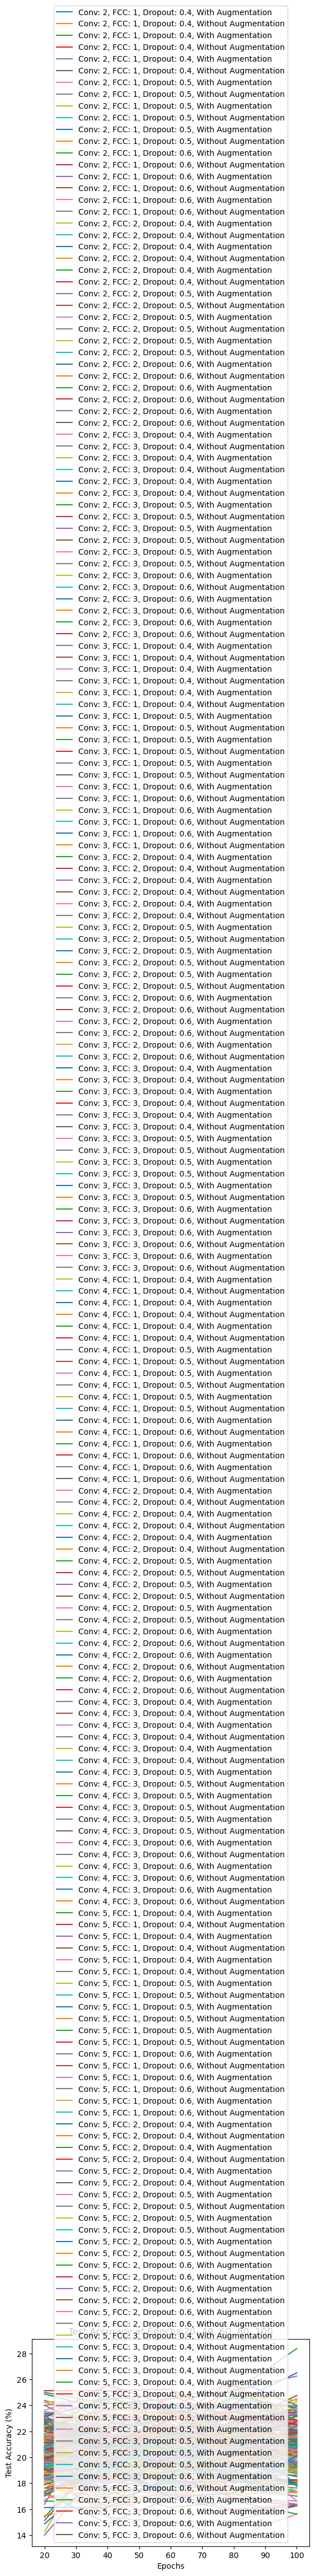

In [12]:
results = hyperparameter_tuning(train_loader, test_loader)
plot_results(results)

In [13]:
print(results)

[{'conv_layers': 2, 'fcc_layers': 1, 'dropout_prob': 0.4, 'weight_decay': 0.0001, 'augment': True, 'test_accuracies': [21.75, 22.375, 23.625, 22.875, 23.75], 'checkpoint_epochs': [20, 40, 60, 80, 100]}, {'conv_layers': 2, 'fcc_layers': 1, 'dropout_prob': 0.4, 'weight_decay': 0.0001, 'augment': False, 'test_accuracies': [17.625, 16.875, 17.125, 17.625, 17.25], 'checkpoint_epochs': [20, 40, 60, 80, 100]}, {'conv_layers': 2, 'fcc_layers': 1, 'dropout_prob': 0.4, 'weight_decay': 0.001, 'augment': True, 'test_accuracies': [19.125, 21.625, 20.375, 21.0, 21.125], 'checkpoint_epochs': [20, 40, 60, 80, 100]}, {'conv_layers': 2, 'fcc_layers': 1, 'dropout_prob': 0.4, 'weight_decay': 0.001, 'augment': False, 'test_accuracies': [17.625, 18.625, 20.125, 17.625, 17.0], 'checkpoint_epochs': [20, 40, 60, 80, 100]}, {'conv_layers': 2, 'fcc_layers': 1, 'dropout_prob': 0.4, 'weight_decay': 0.01, 'augment': True, 'test_accuracies': [20.75, 20.5, 20.25, 21.0, 20.25], 'checkpoint_epochs': [20, 40, 60, 80, 10

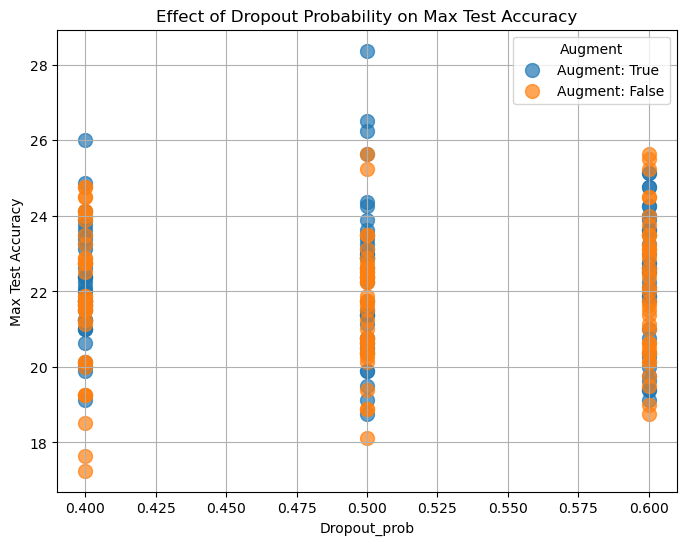

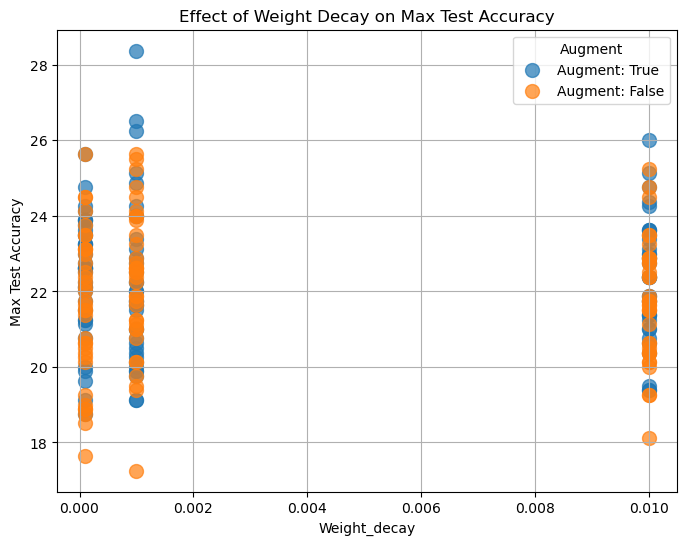

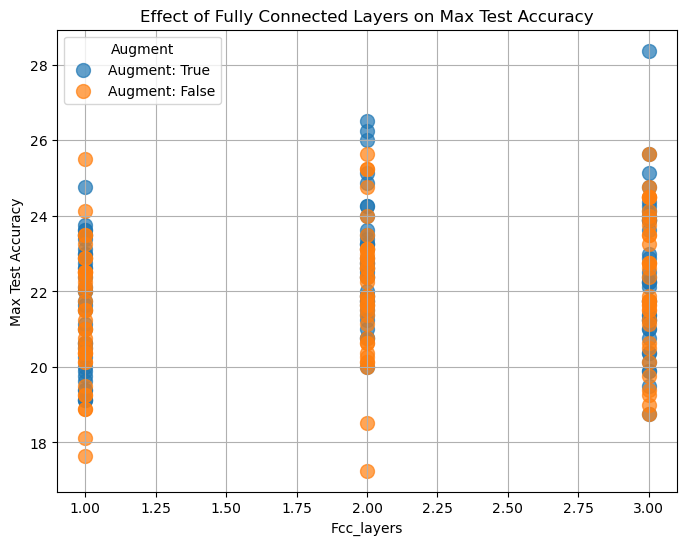

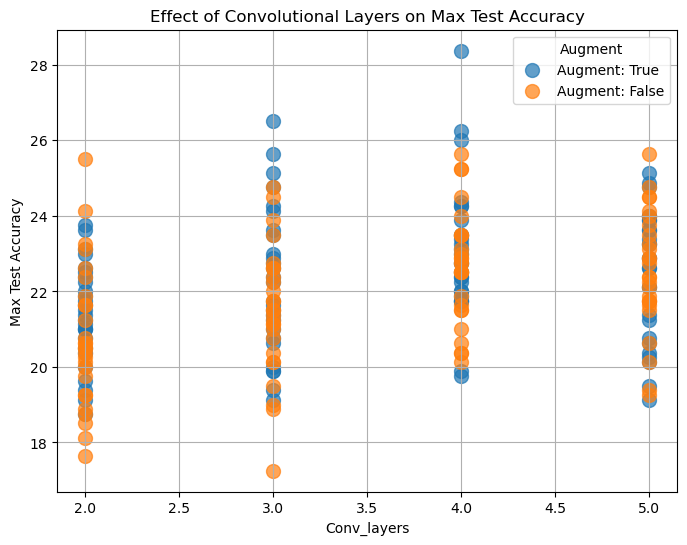

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data (replace this with your full list of dicts)


# Convert data into a DataFrame
df = pd.DataFrame(results)

# Calculate max test accuracy for each configuration
df['max_accuracy'] = df['test_accuracies'].apply(max)

# Function to plot a variable against max_accuracy, keeping others constant
def plot_param_variation(df, param, title):
    plt.figure(figsize=(8,6))
    for augment in df['augment'].unique():
        subset = df[df['augment'] == augment]
        plt.scatter(subset[param], subset['max_accuracy'], label=f'Augment: {augment}', s=100, alpha=0.7)
    plt.title(title)
    plt.ylabel("Max Test Accuracy")
    plt.xlabel(param.capitalize())
    plt.legend(title='Augment')
    plt.grid(True)
    plt.show()

# Plot 1: Varying dropout_prob
plot_param_variation(df, 'dropout_prob', 'Effect of Dropout Probability on Max Test Accuracy')

# Plot 2: Varying weight_decay
plot_param_variation(df, 'weight_decay', 'Effect of Weight Decay on Max Test Accuracy')

# Plot 3: Varying fcc_layers
plot_param_variation(df, 'fcc_layers', 'Effect of Fully Connected Layers on Max Test Accuracy')

# Plot 4: Varying conv_layers
plot_param_variation(df, 'conv_layers', 'Effect of Convolutional Layers on Max Test Accuracy')


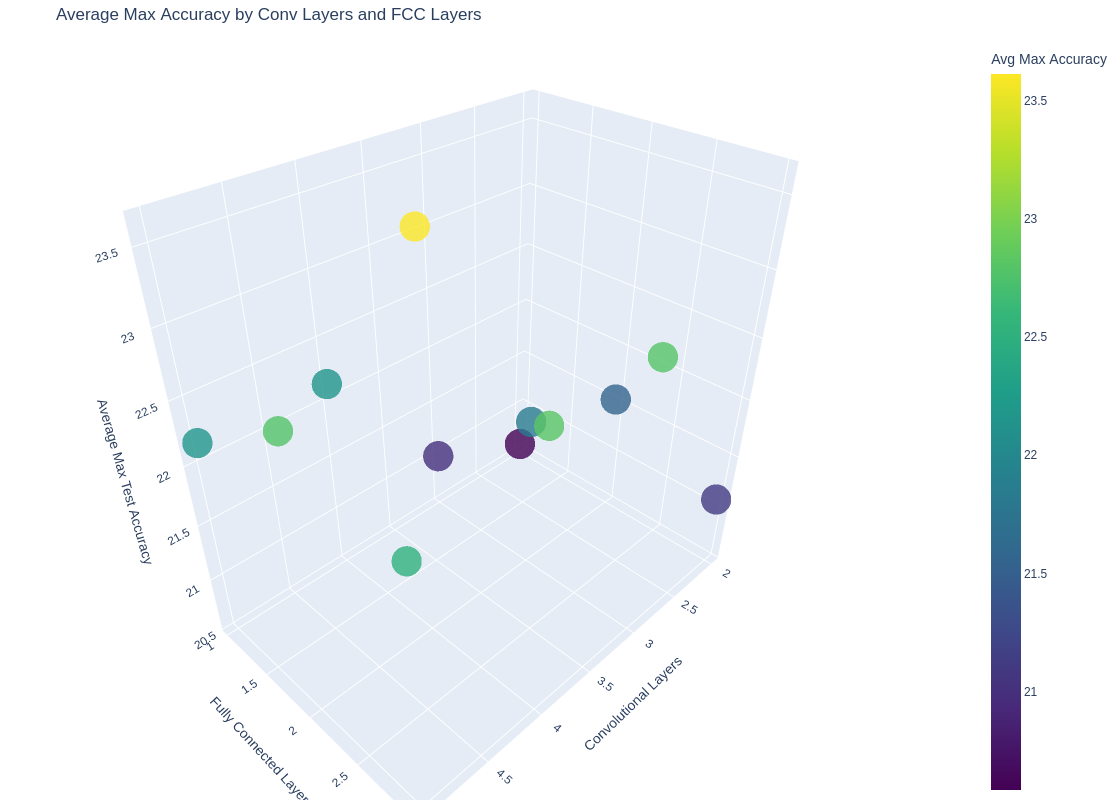

In [22]:
import pandas as pd
import plotly.graph_objects as go

# Convert results data into a DataFrame
df = pd.DataFrame(results)

# Calculate max test accuracy for each configuration
df['max_accuracy'] = df['test_accuracies'].apply(max)

# Group by 'conv_layers' and 'fcc_layers' and calculate the average of max_accuracy
grouped_df = df.groupby(['conv_layers', 'fcc_layers']).agg(avg_max_accuracy=('max_accuracy', 'mean')).reset_index()

# Create 3D scatter plot with Plotly
fig = go.Figure(data=[go.Scatter3d(
    x=grouped_df['conv_layers'],
    y=grouped_df['fcc_layers'],
    z=grouped_df['avg_max_accuracy'],
    mode='markers',
    marker=dict(
        size=10,
        color=grouped_df['avg_max_accuracy'],  # Set color to average max accuracy
        colorscale='Viridis',      # Colorscale for accuracy
        opacity=0.8,
        colorbar=dict(title='Avg Max Accuracy')
    )
)])

# Update plot layout
fig.update_layout(
    title='Average Max Accuracy by Conv Layers and FCC Layers',
    scene=dict(
        xaxis_title='Convolutional Layers',
        yaxis_title='Fully Connected Layers',
        zaxis_title='Average Max Test Accuracy'
    ),
    autosize=False,
    width=1000,  # Adjust width
    height=800,  # Adjust height
    margin=dict(l=0, r=0, b=0, t=40)  # Set margins to reduce whitespace
)

# Show the plot
fig.show()


In [23]:
RESULTS = results

### looks like 4 conv layers and 2 fcc layers are optimal. .001 for weight decay and .5 for dropout rate